In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def show(img):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

def imshow(img):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### 1. 读取图像

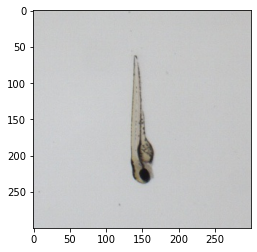

In [3]:
# 读取彩色图像
img_bgr = cv.imread('./data/test2.jpg')
show(img_bgr)

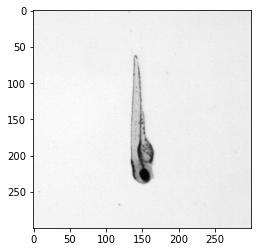

In [4]:
# 读取灰度图像
img_gray = cv.imread('data/test2.jpg', 0)
show(img_gray)

### 2. 中值滤波去噪

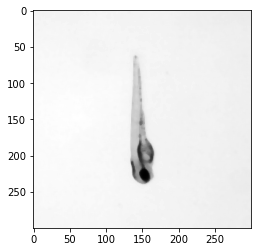

In [5]:
# 中值滤波
img_median = cv.medianBlur(img_gray, ksize=5)
show(img_median)

### 3. 自适应阈值分割
```
这里取如下参数的目的：尽可能保留原图的细节，并验证程序的适应性。
```

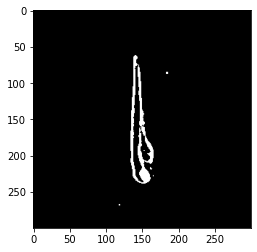

In [6]:
# 自适应阈值分割
blocksize = 5
thresh = 4
img_bin = cv.adaptiveThreshold(img_median, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                       cv.THRESH_BINARY_INV, 2 * int(blocksize) + 1, int(thresh))
show(img_bin)

```
取如下参数，在本图中可以实现完全去噪
```

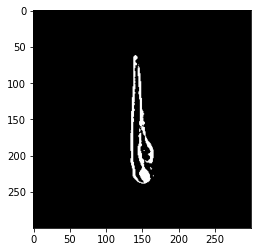

In [7]:
# 自适应阈值分割
blocksize = 5
thresh = 5
img_bin2 = cv.adaptiveThreshold(img_median, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                       cv.THRESH_BINARY_INV, 2 * int(blocksize) + 1, int(thresh))
show(img_bin2)

```
损失的细节：
```

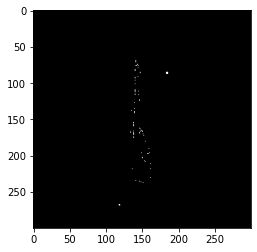

In [8]:
show(img_bin - img_bin2)

### 4. 形态学闭运算

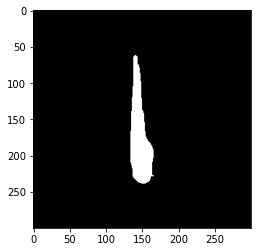

In [9]:
# 形态学闭运算，先膨胀后腐蚀
kernel = cv.getStructuringElement(cv.MORPH_RECT, (15, 15))
img_morph = cv.morphologyEx(img_bin2, cv.MORPH_CLOSE, kernel)
show(img_morph)

### 5. 查找轮廓

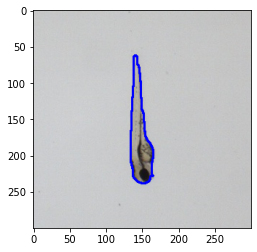

In [10]:
# 查找轮廓
contours, hierarchy = cv.findContours(img_morph, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
# 绘制轮廓
img_contours = img_bgr.copy()  # 复制原图片获得显示的图片
cv.drawContours(img_contours, contours, -1, (255, 0, 0), 2)
show(img_contours)

```
排除可能存在噪声的影响：查找最大轮廓
为了更精确地找到吸持点：采用填充的方式
```

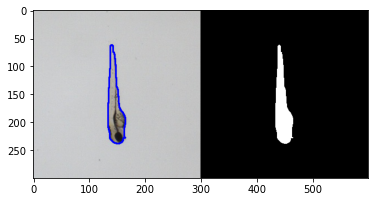

In [11]:
# 查找最大轮廓
index, max_area = 0, 0
for c in range(len(contours)):
    area = cv.contourArea(contours[c])
    if area > max_area:
        max_area = area
        index = c

# 在原图中绘制最大轮廓
img_contMAX = img_bgr.copy()
cv.drawContours(img_contMAX, contours, index, (255, 0, 0), 2)  # 绘制轮廓

# 将最大轮廓填充绘制在img_targetFind中
h, w, c = img_bgr.shape
img_targetFind = np.zeros((w, h), np.uint8)
cv.drawContours(img_targetFind, contours, index, 255, -1)  # 绘制轮廓

show(np.hstack([img_contMAX, cv.merge([img_targetFind, img_targetFind, img_targetFind])]))

### 6. 寻找吸持点

In [12]:
# 寻找吸持点
box = []
j_min, j_max, find = 0, 0, 0
for i in range(h):
    for j in range(w):
        if img_targetFind[i, j] == 255:
            if find == 0:
                j_min = j
                j_max = j
                find = 1
            else:
                j_max = j
    if find == 1:
        box.append([i, j_min, j_max])
        find = 0

Max = 0
target = []
for a in box:
    x = a[2] - a[1]
    if x > Max:
        Max = x
        target = (a[1], a[0])
print("吸持点坐标：", target) # 吸持点坐标

吸持点坐标： (134, 192)


### 7. 标记吸持点

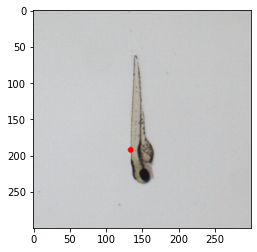

In [13]:
img = img_bgr.copy()
cv.circle(img, target, 4, (0, 0, 255), -1)
show(img)

### Imgs

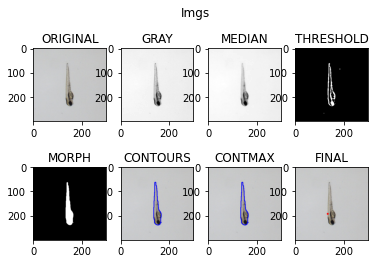

In [14]:
plt.subplot(241), imshow(img_bgr), plt.title('ORIGINAL')
plt.subplot(242), imshow(img_gray), plt.title('GRAY')
plt.subplot(243), imshow(img_median), plt.title('MEDIAN')
plt.subplot(244), imshow(img_bin), plt.title('THRESHOLD')
plt.subplot(245), imshow(img_morph), plt.title('MORPH')
plt.subplot(246), imshow(img_contours), plt.title('CONTOURS')
plt.subplot(247), imshow(img_contMAX), plt.title('CONTMAX')
plt.subplot(248), imshow(img), plt.title('FINAL')
plt.suptitle('Imgs')
plt.savefig('./data/Imgs2.jpg')
plt.show()